**Task 2**

Image reconstruction using Randon Forest

In [1]:
import requests

url = "https://images.unsplash.com/photo-1518467166778-b88f373ffec7?q=80&w=1931&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
response = requests.get(url)

# Save the image
with open("image.jpg", "wb") as file:
    file.write(response.content)

print("Image downloaded successfully!")


Image downloaded successfully!


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [3]:
img = torchvision.io.read_image("image.jpg")
print(img.shape)

torch.Size([3, 1086, 1931])


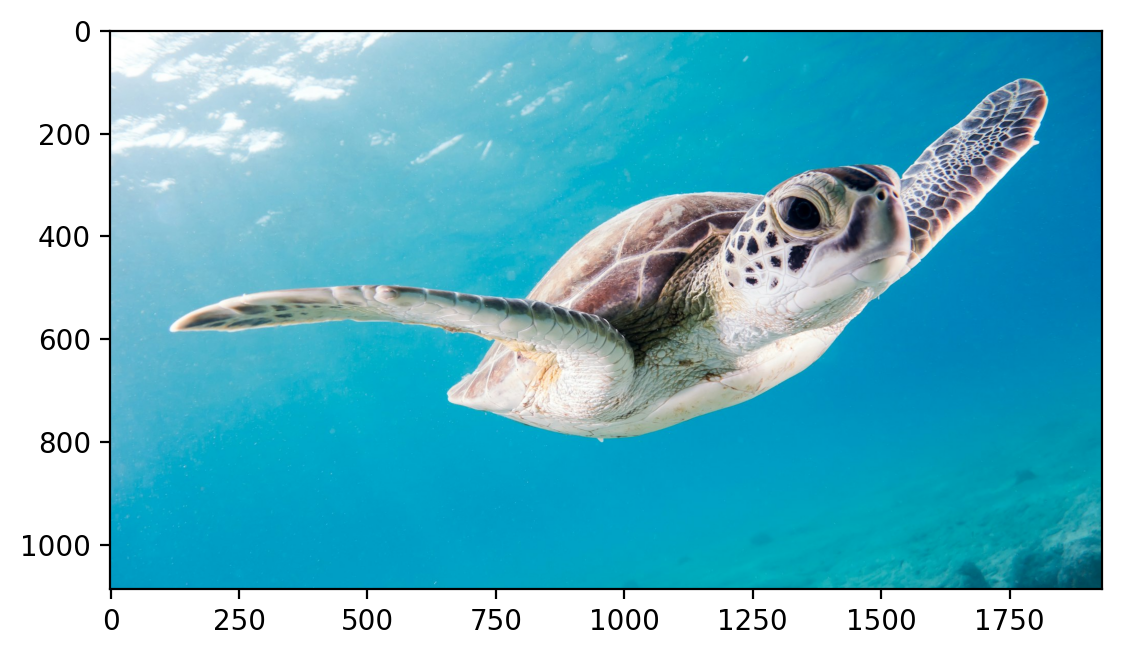

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.9451, 0.9412, 0.9333,  ..., 0.0000, 0.0000, 0.0000],
         [0.9490, 0.9451, 0.9412,  ..., 0.0000, 0.0000, 0.0000],
         [0.9608, 0.9490, 0.9451,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0039, 0.0039, 0.0000,  ..., 0.0078, 0.0118, 0.0157],
         [0.0039, 0.0000, 0.0000,  ..., 0.0314, 0.0314, 0.0353],
         [0.0000, 0.0000, 0.0000,  ..., 0.0627, 0.0627, 0.0667]],

        [[0.9765, 0.9725, 0.9725,  ..., 0.4275, 0.4275, 0.4275],
         [0.9804, 0.9765, 0.9725,  ..., 0.4275, 0.4275, 0.4275],
         [0.9804, 0.9804, 0.9765,  ..., 0.4275, 0.4275, 0.4275],
         ...,
         [0.6000, 0.6000, 0.5961,  ..., 0.3137, 0.3176, 0.3137],
         [0.6000, 0.5961, 0.5961,  ..., 0.3176, 0.3216, 0.3255],
         [0.5961, 0.5961, 0.5961,  ..., 0.3451, 0.3451, 0.3490]],

        [[0.9843, 0.9804, 0.9765,  ..., 0.6196, 0.6196, 0.6196],
         [0.9882, 0.9843, 0.9804,  ..., 0.6196, 0.6196, 0.6196],
         [0.9961, 0.9922, 0.9882,  ..., 0.6196, 0.6196, 0.

In [8]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [9]:
img_X, img_Y = create_coordinate_map(img)

img_X.shape, img_Y.shape

(torch.Size([2097066, 2]), torch.Size([2097066, 3]))

In [10]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [11]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [12]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()
train(net, 0.01, img_X_scaled, img_Y, 1000)

Epoch 0 loss: 25760.066406
Epoch 100 loss: 25440.787109
Epoch 200 loss: 25126.332031
Epoch 300 loss: 24816.593750
Epoch 400 loss: 24511.416016
Epoch 500 loss: 24210.623047
Epoch 600 loss: 23914.072266
Epoch 700 loss: 23621.638672
Epoch 800 loss: 23333.191406
Epoch 900 loss: 23048.615234


22770.580078125

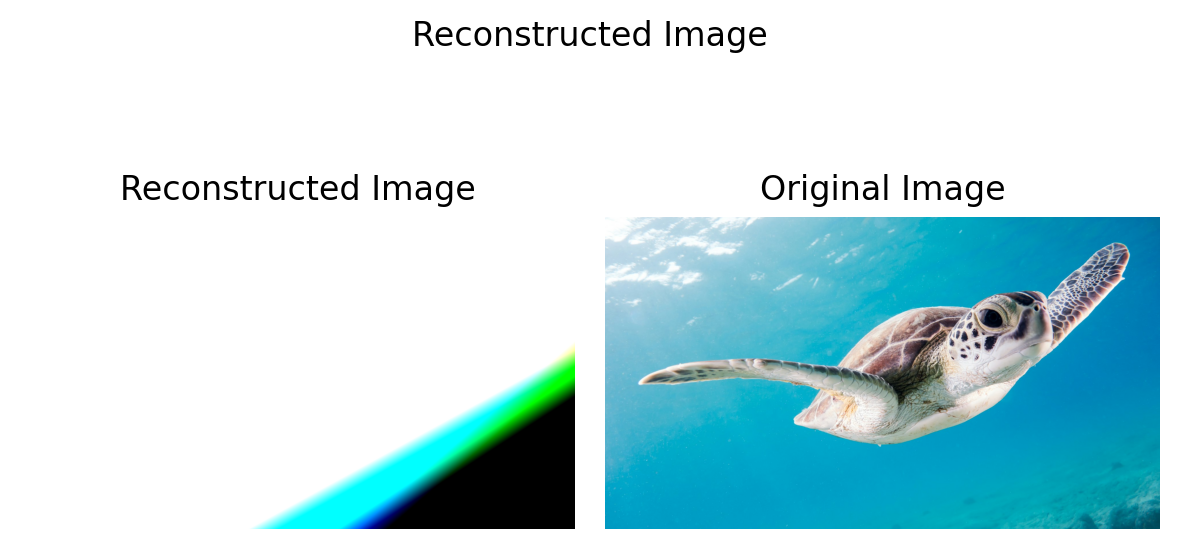

In [13]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    Plots the original and reconstructed image side by side.
    
    Args:
    - original_img: The original image tensor (torch.Tensor of shape (C, H, W))
    - net: The trained neural network model
    - X: Input coordinates (torch.Tensor of shape (num_samples, 2))
    - title: Title for the plot (str)
    """
    num_channels, height, width = original_img.shape
    
    # Switch model to evaluation mode and predict pixel values
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

        # Clamp the outputs to the range [0, 1] for float images
        outputs = torch.clamp(outputs, 0.0, 1.0)
    
    # Create a figure for comparison
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Plot reconstructed image
    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    
    # Plot original image
    ax1.imshow(original_img.cpu().permute(1, 2, 0))  # Move channels to the last dimension
    ax1.set_title("Original Image")
    
    # Remove axes for both plots
    for a in [ax0, ax1]:
        a.axis("off")

    # Set the overall plot title and adjust layout
    fig.suptitle(title, y=0.9)
    plt.tight_layout()

# Call the function again with clamping
plot_reconstructed_and_original_image(img, net, img_X_scaled, title="Reconstructed Image")


In [32]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)
X_rff = create_rff_features(img_X_scaled, 1000, 0.008)
X_rff.shape